In [0]:
from google.colab import drive
drive.mount('/content/drive')




In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

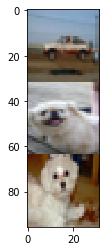

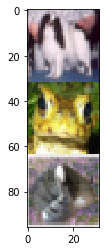

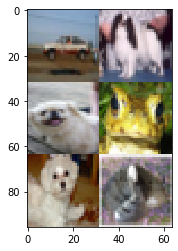

torch.Size([3, 96, 32])


In [9]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



6


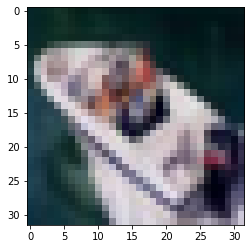

ship


In [12]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.001, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 280
every_what_epoch = 20
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
      print(epoch,"updating what_net, where_net is freezed")
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
      print(epoch,"updating where_net, what_net is freezed")
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
          optimizer_what.step()
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
          optimizer_where.step()
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10042.0 Total: 30000 train_loss 1.1019589887835586 train_acc:  0.3347333333333333
total_Correct: 3395.0 Total: 10000 test loss:  1.098560336933732 test accuracy 0.3395
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10004.0 Total: 30000 train_loss 1.0986945269776063 train_acc:  0.3334666666666667
total_Correct: 3395.0 Total: 10000 test loss:  1.0985532822390365 test accuracy 0.3395
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10189.0 Total: 30000 train_loss 1.0985597447224718 train_acc:  0.33963333333333334
total_Correct: 3316.0 Total: 10000 test loss:  1.098782595165749 test accuracy 0.3316
3 updating what_net, where_net is freezed
--------

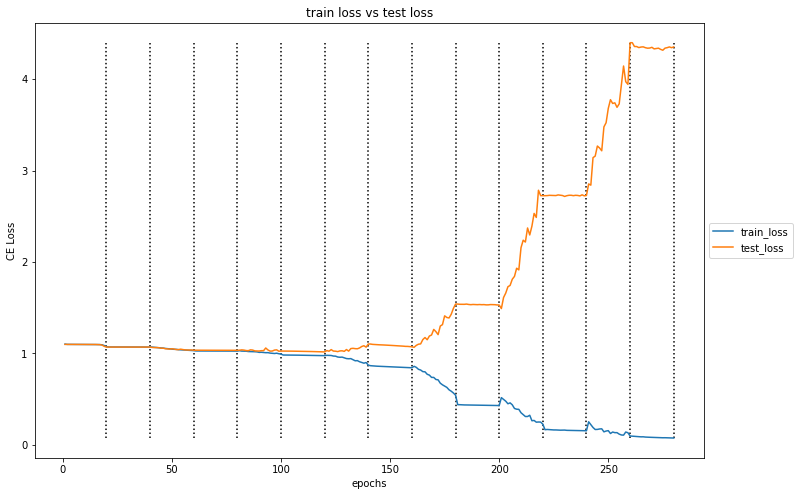

In [23]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


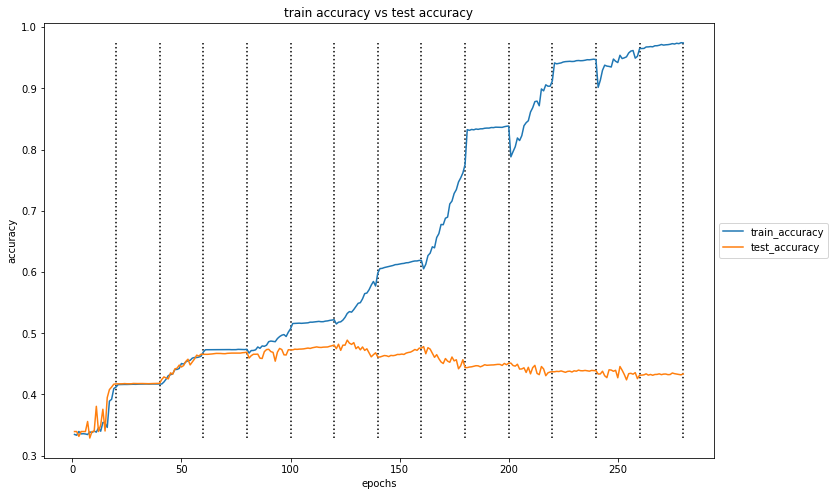

In [24]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [26]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   1515                   18443
1        5             0  ...                   1341                   18593
2       10             0  ...                   1302                   18543
3       15             0  ...                   1290                   18323
4       20             0  ...                   1486                   16029
5       25             0  ...                   2053                   15450
6       30             0  ...                   3037                   14455
7       35             0  ...                   3971                   13515
8       40             0  ...                   4008                   13478
9       45             0  ...                   3993                   12997
10      50             0  ...                   3798                   12714
11      55             0  ...                   3701                   12486
12      60             0  ...                   3696                   12112
13      65             0  ...                   3865                   11940
14      70             0  ...                   3818                   11979
15      75             0  ...                   3710                   12079
16      80             0  ...                   3692                   12278
17      85             0  ...                   3656                   12083
18      90             0  ...                   3541                   11841
19      95             0  ...                   3443                   11653
20     100             0  ...                   3128                   11395
21     105             0  ...                   3137                   11367
22     110             0  ...                   3157                   11289
23     115             0  ...                   3305                   11101
24     120             0  ...                   3715                   10831
25     125             0  ...                   3612                   10418
26     130             0  ...                   3507                   10027
27     135             0  ...                   3307                    9563
28     140             0  ...                   2792                    9040
29     145             0  ...                   2767                    8935
30     150             0  ...                   2846                    8743
31     155             0  ...                   2909                    8571
32     160             0  ...                   3103                    8739
33     165             0  ...                   2833                    7982
34     170             0  ...                   2477                    6888
35     175             0  ...                   2123                    5842
36     180             0  ...                   1335                    3691
37     185             0  ...                   1367                    3645
38     190             0  ...                   1378                    3572
39     195             0  ...                   1353                    3552
40     200             0  ...                   1834                    4525
41     205             0  ...                   1565                    3757
42     210             0  ...                   1148                    2805
43     215             0  ...                    879                    2246
44     220             0  ...                    531                    1227
45     225             0  ...                    501                    1193
46     230             0  ...                    488                    1160
47     235             0  ...                    485                    1115
48     240             0  ...                    842                    2113
49     245             0  ...                    573                    1356
50     250             0  ...                    428                     955


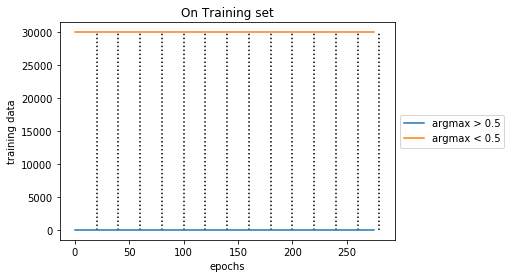

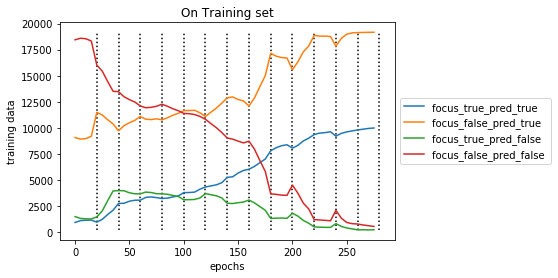

In [27]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [28]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    431                    6174
1        5             0  ...                    431                    6174
2       10             0  ...                    481                    5712
3       15             0  ...                    416                    5635
4       20             0  ...                    473                    5354
5       25             0  ...                    686                    5139
6       30             0  ...                   1021                    4800
7       35             0  ...                   1374                    4448
8       40             0  ...                   1398                    4356
9       45             0  ...                   1466                    4203
10      50             0  ...                   1225                    4303
11      55             0  ...                   1269                    4151
12      60             0  ...                   1277                    4067
13      65             0  ...                   1345                    3984
14      70             0  ...                   1350                    3978
15      75             0  ...                   1309                    4016
16      80             0  ...                   1197                    4208
17      85             0  ...                   1104                    4303
18      90             0  ...                   1113                    4187
19      95             0  ...                   1254                    4012
20     100             0  ...                   1137                    4134
21     105             0  ...                   1164                    4091
22     110             0  ...                   1202                    4028
23     115             0  ...                   1257                    3969
24     120             0  ...                   1396                    3856
25     125             0  ...                   1329                    3783
26     130             0  ...                   1343                    3877
27     135             0  ...                   1374                    3947
28     140             0  ...                   1323                    4065
29     145             0  ...                   1311                    4051
30     150             0  ...                   1370                    3970
31     155             0  ...                   1408                    3881
32     160             0  ...                   1483                    3735
33     165             0  ...                   1436                    3957
34     170             0  ...                   1510                    3903
35     175             0  ...                   1484                    3949
36     180             0  ...                   1527                    4034
37     185             0  ...                   1563                    3969
38     190             0  ...                   1583                    3937
39     195             0  ...                   1591                    3918
40     200             0  ...                   1617                    3870
41     205             0  ...                   1662                    3921
42     210             0  ...                   1626                    3936
43     215             0  ...                   1621                    3962
44     220             0  ...                   1639                    3990
45     225             0  ...                   1694                    3944
46     230             0  ...                   1656                    3964
47     235             0  ...                   1635                    3978
48     240             0  ...                   1690                    3976
49     245             0  ...                   1664                    3933
50     250             0  ...                   1658                    3885


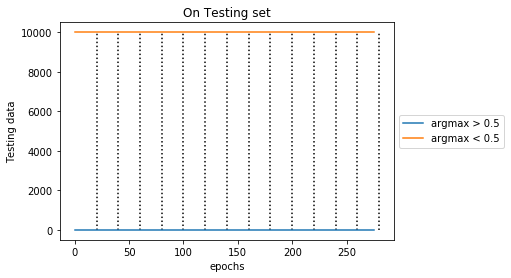

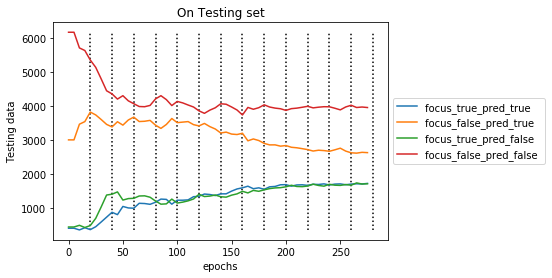

In [29]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [30]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000]
focus_true_pred_true [956, 1130, 1169, 1181, 985, 1252, 1711, 2128, 2777, 2792, 2987,

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_280epochs_every20epoch_where_lr_001_what_lr_01/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


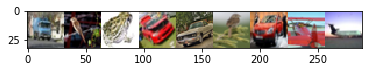

tensor([0.0768, 0.0730, 0.0860, 0.1200, 0.0822, 0.1658, 0.0831, 0.1673, 0.1457],
       device='cuda:0', dtype=torch.float64)


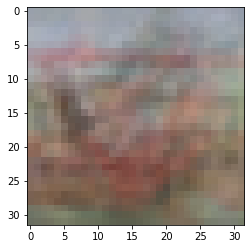

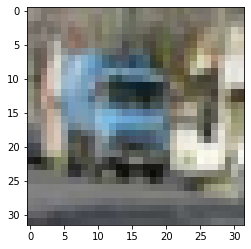

predicted truck
true truck
****************************************************************************************************


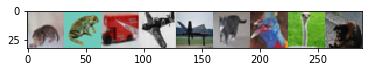

tensor([0.0979, 0.1241, 0.1084, 0.1155, 0.1678, 0.1049, 0.0815, 0.1071, 0.0928],
       device='cuda:0', dtype=torch.float64)


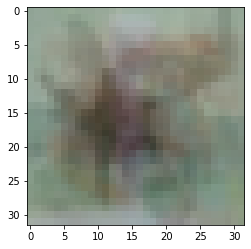

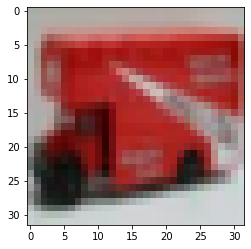

predicted truck
true truck
****************************************************************************************************


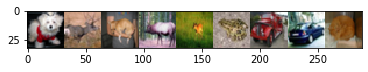

tensor([0.1159, 0.1161, 0.0920, 0.0843, 0.0902, 0.1207, 0.1701, 0.1122, 0.0983],
       device='cuda:0', dtype=torch.float64)


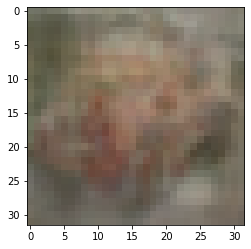

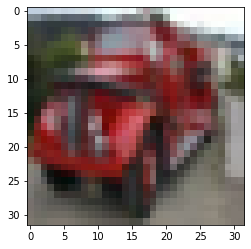

predicted truck
true truck
****************************************************************************************************


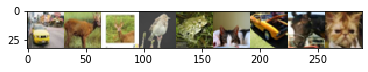

tensor([0.1475, 0.1089, 0.1308, 0.0936, 0.0795, 0.0842, 0.0890, 0.1691, 0.0974],
       device='cuda:0', dtype=torch.float64)


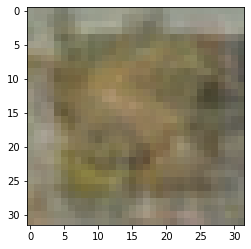

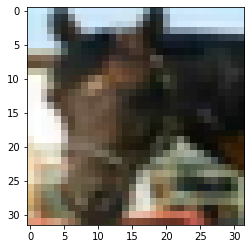

predicted horse
true horse
****************************************************************************************************


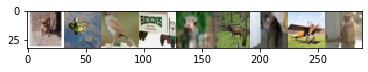

tensor([0.1081, 0.1051, 0.0846, 0.1038, 0.0935, 0.1053, 0.1118, 0.1984, 0.0895],
       device='cuda:0', dtype=torch.float64)


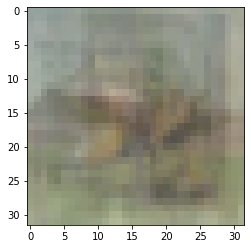

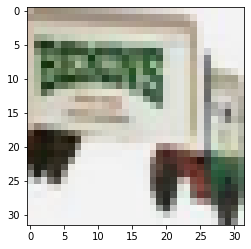

predicted truck
true truck
****************************************************************************************************


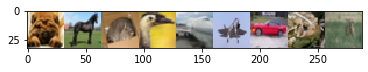

tensor([0.0810, 0.2549, 0.0835, 0.0997, 0.1189, 0.0807, 0.0859, 0.0898, 0.1055],
       device='cuda:0', dtype=torch.float64)


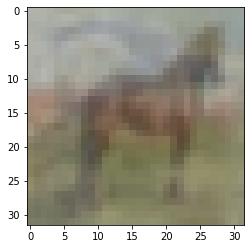

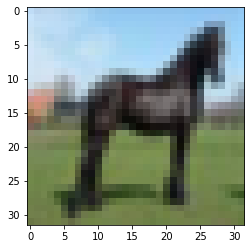

predicted horse
true horse
****************************************************************************************************


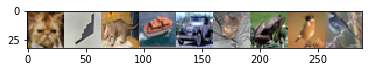

tensor([0.0983, 0.0957, 0.0953, 0.1282, 0.1882, 0.0856, 0.1111, 0.0948, 0.1028],
       device='cuda:0', dtype=torch.float64)


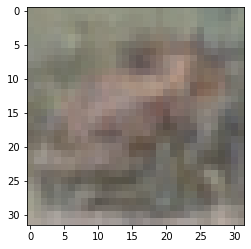

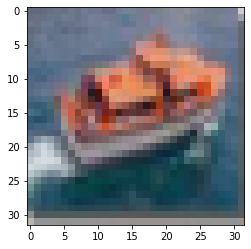

predicted ship
true ship
****************************************************************************************************


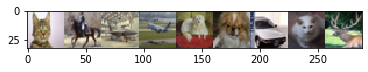

tensor([0.1222, 0.1224, 0.0857, 0.1211, 0.0875, 0.1157, 0.1711, 0.0918, 0.0825],
       device='cuda:0', dtype=torch.float64)


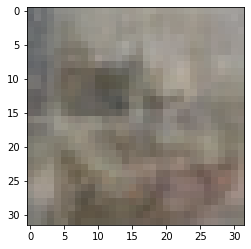

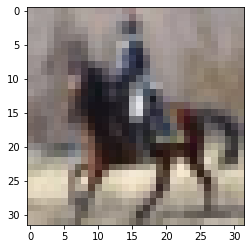

predicted horse
true horse
****************************************************************************************************


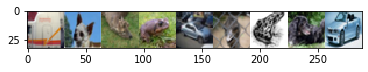

tensor([0.1365, 0.1409, 0.0974, 0.1164, 0.0979, 0.1018, 0.1149, 0.0820, 0.1122],
       device='cuda:0', dtype=torch.float64)


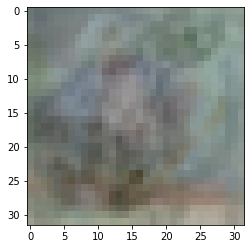

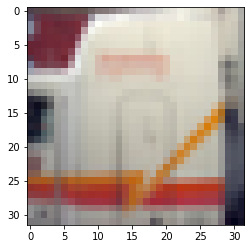

predicted truck
true truck
****************************************************************************************************


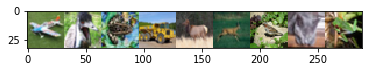

tensor([0.0912, 0.0893, 0.1108, 0.2177, 0.0839, 0.0975, 0.0994, 0.1014, 0.1088],
       device='cuda:0', dtype=torch.float64)


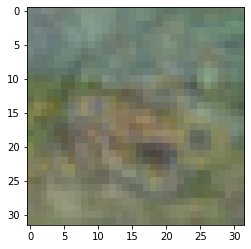

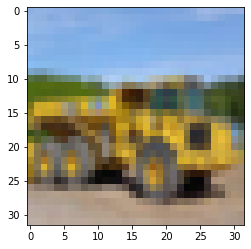

predicted truck
true truck
****************************************************************************************************


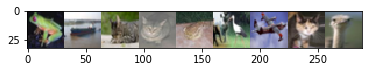

tensor([0.0863, 0.1789, 0.0974, 0.1076, 0.0986, 0.1042, 0.1103, 0.0785, 0.1382],
       device='cuda:0', dtype=torch.float64)


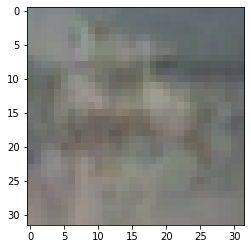

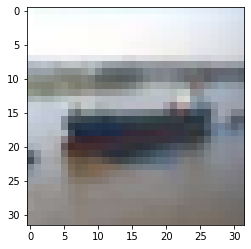

predicted ship
true ship
****************************************************************************************************


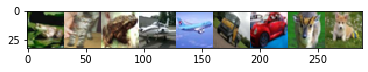

tensor([0.0737, 0.0947, 0.1522, 0.1256, 0.0810, 0.1282, 0.1561, 0.0946, 0.0939],
       device='cuda:0', dtype=torch.float64)


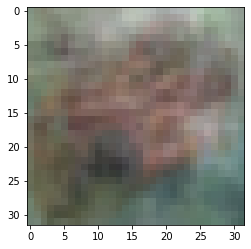

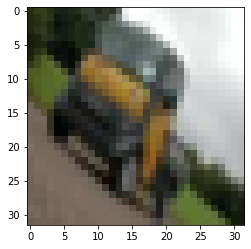

predicted truck
true truck
****************************************************************************************************


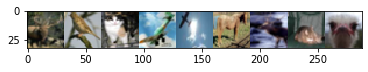

tensor([0.0851, 0.0884, 0.1048, 0.1019, 0.0899, 0.1201, 0.1252, 0.0949, 0.1898],
       device='cuda:0', dtype=torch.float64)


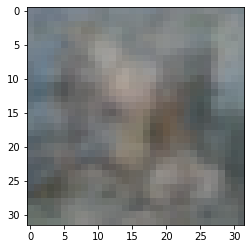

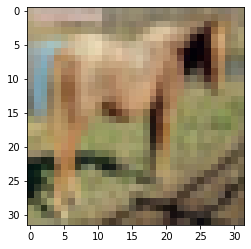

predicted horse
true horse
****************************************************************************************************


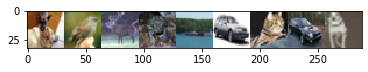

tensor([0.1027, 0.0891, 0.0743, 0.0938, 0.2546, 0.1186, 0.1012, 0.0728, 0.0929],
       device='cuda:0', dtype=torch.float64)


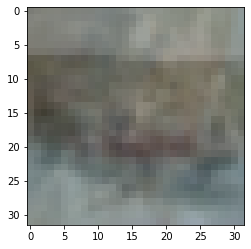

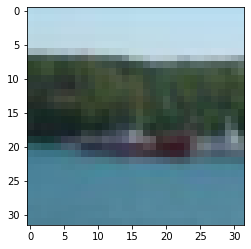

predicted ship
true ship
****************************************************************************************************


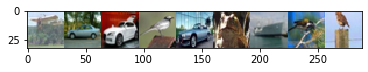

tensor([0.1625, 0.0778, 0.0662, 0.0951, 0.1336, 0.0949, 0.1317, 0.1465, 0.0917],
       device='cuda:0', dtype=torch.float64)


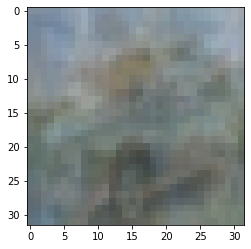

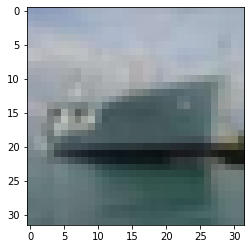

predicted ship
true ship
****************************************************************************************************


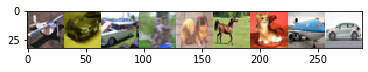

tensor([0.0813, 0.0769, 0.1655, 0.1189, 0.1123, 0.0938, 0.1175, 0.1117, 0.1222],
       device='cuda:0', dtype=torch.float64)


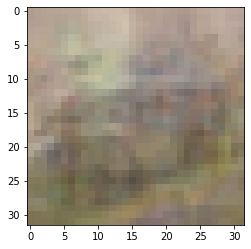

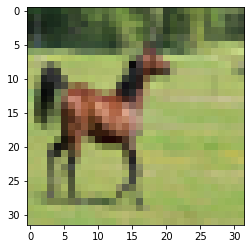

predicted horse
true horse
****************************************************************************************************


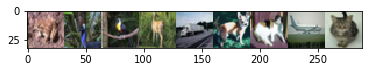

tensor([0.1335, 0.0956, 0.0873, 0.0926, 0.1650, 0.0933, 0.0829, 0.1298, 0.1200],
       device='cuda:0', dtype=torch.float64)


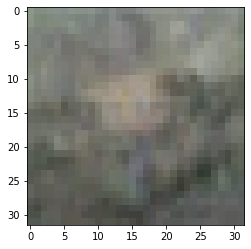

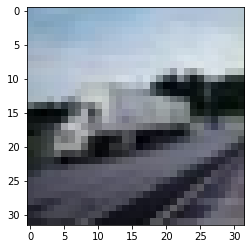

predicted truck
true truck
****************************************************************************************************


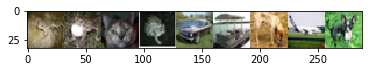

tensor([0.0859, 0.0890, 0.0726, 0.0704, 0.1617, 0.1432, 0.1296, 0.1431, 0.1044],
       device='cuda:0', dtype=torch.float64)


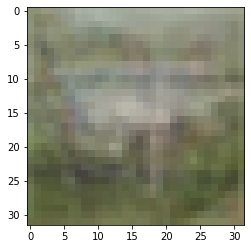

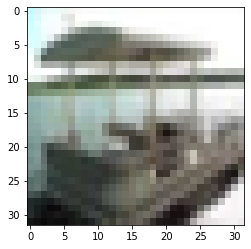

predicted ship
true ship
****************************************************************************************************


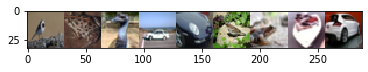

tensor([0.0920, 0.0869, 0.1111, 0.1494, 0.1111, 0.0971, 0.1375, 0.1216, 0.0931],
       device='cuda:0', dtype=torch.float64)


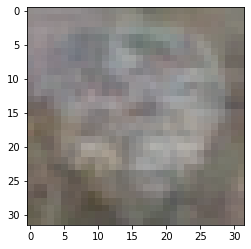

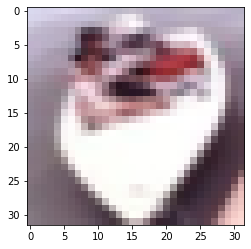

predicted ship
true ship
****************************************************************************************************


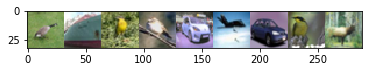

tensor([0.0993, 0.1741, 0.1211, 0.0908, 0.0930, 0.1053, 0.0972, 0.1060, 0.1134],
       device='cuda:0', dtype=torch.float64)


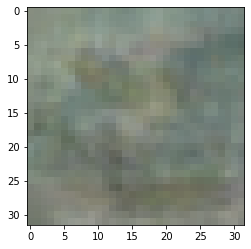

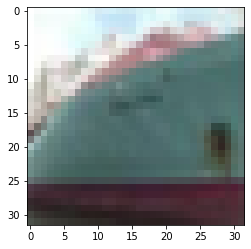

predicted ship
true ship
****************************************************************************************************


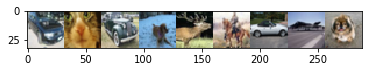

tensor([0.0974, 0.0980, 0.1025, 0.0784, 0.0918, 0.1552, 0.0793, 0.1493, 0.1480],
       device='cuda:0', dtype=torch.float64)


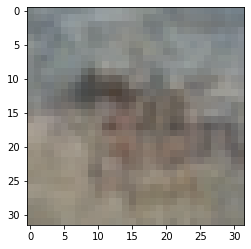

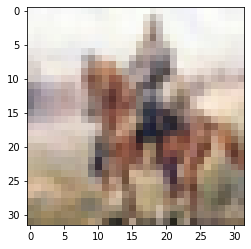

predicted horse
true horse
****************************************************************************************************


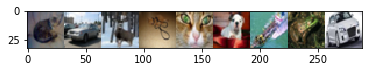

tensor([0.0995, 0.1599, 0.0755, 0.0956, 0.1089, 0.1241, 0.1055, 0.0769, 0.1541],
       device='cuda:0', dtype=torch.float64)


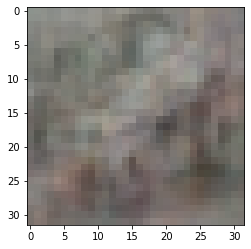

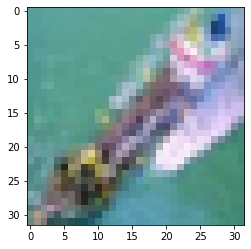

predicted ship
true ship
****************************************************************************************************


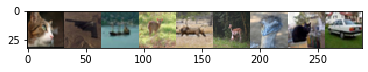

tensor([0.1036, 0.1065, 0.0918, 0.1193, 0.1371, 0.0998, 0.0959, 0.1321, 0.1139],
       device='cuda:0', dtype=torch.float64)


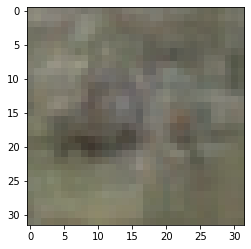

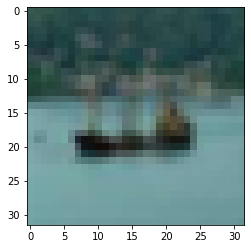

predicted ship
true ship
****************************************************************************************************


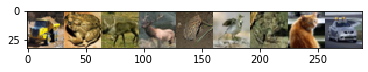

tensor([0.1033, 0.0984, 0.1121, 0.1094, 0.0963, 0.1125, 0.1111, 0.1175, 0.1395],
       device='cuda:0', dtype=torch.float64)


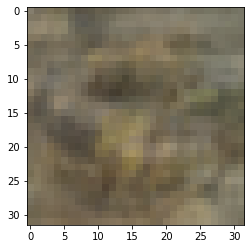

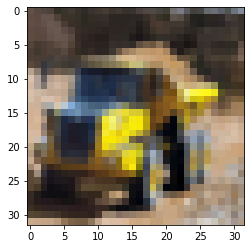

predicted truck
true truck
****************************************************************************************************


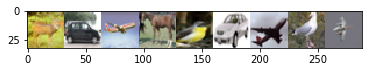

tensor([0.1084, 0.1116, 0.0829, 0.1211, 0.1011, 0.1105, 0.1538, 0.1057, 0.1049],
       device='cuda:0', dtype=torch.float64)


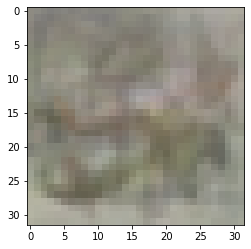

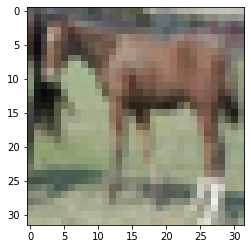

predicted horse
true horse
****************************************************************************************************


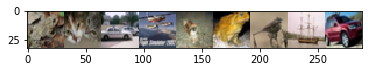

tensor([0.0888, 0.0897, 0.1177, 0.0896, 0.1021, 0.0868, 0.1168, 0.1525, 0.1560],
       device='cuda:0', dtype=torch.float64)


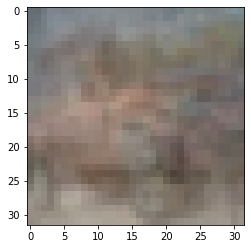

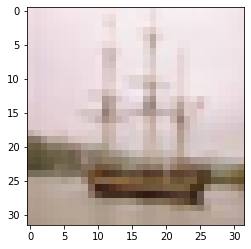

predicted ship
true ship
****************************************************************************************************


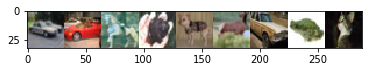

tensor([0.0836, 0.1106, 0.1157, 0.1236, 0.1207, 0.1214, 0.1053, 0.1317, 0.0874],
       device='cuda:0', dtype=torch.float64)


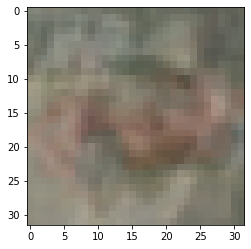

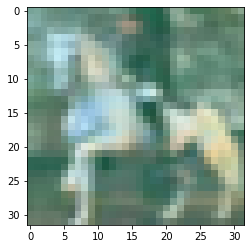

predicted horse
true horse
****************************************************************************************************


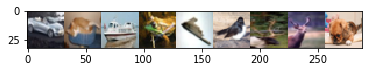

tensor([0.0879, 0.1185, 0.1482, 0.0788, 0.1112, 0.1407, 0.0821, 0.0959, 0.1366],
       device='cuda:0', dtype=torch.float64)


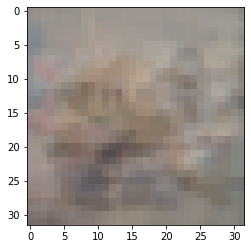

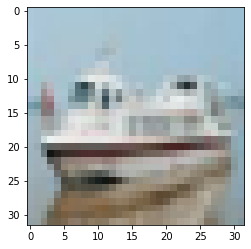

predicted ship
true ship
****************************************************************************************************


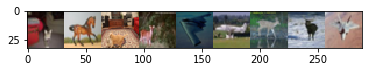

tensor([0.1026, 0.1844, 0.1336, 0.0935, 0.0948, 0.1125, 0.0817, 0.0904, 0.1065],
       device='cuda:0', dtype=torch.float64)


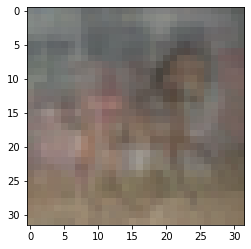

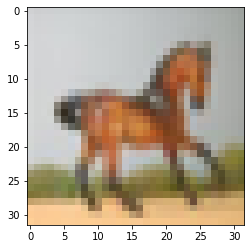

predicted horse
true horse
****************************************************************************************************


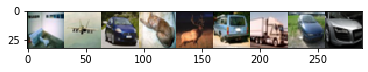

tensor([0.1160, 0.1235, 0.0730, 0.1123, 0.1172, 0.0711, 0.1613, 0.1394, 0.0862],
       device='cuda:0', dtype=torch.float64)


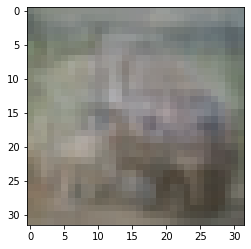

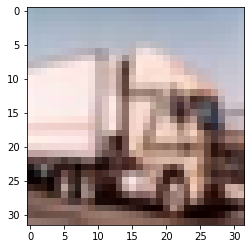

predicted truck
true truck
****************************************************************************************************


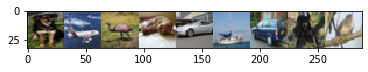

tensor([0.0998, 0.1214, 0.0944, 0.1243, 0.1172, 0.1064, 0.1079, 0.1080, 0.1206],
       device='cuda:0', dtype=torch.float64)


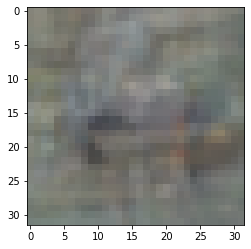

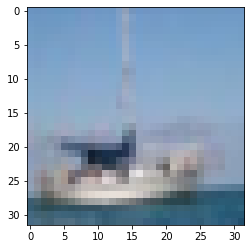

predicted ship
true ship
****************************************************************************************************


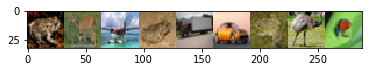

tensor([0.0812, 0.0807, 0.1175, 0.0945, 0.1788, 0.1263, 0.0798, 0.1118, 0.1295],
       device='cuda:0', dtype=torch.float64)


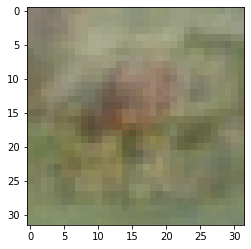

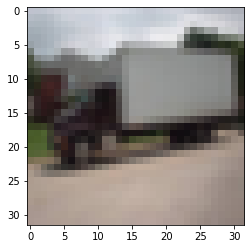

predicted truck
true truck
****************************************************************************************************


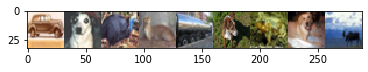

tensor([0.1886, 0.1122, 0.0862, 0.1161, 0.1370, 0.0926, 0.0899, 0.0710, 0.1064],
       device='cuda:0', dtype=torch.float64)


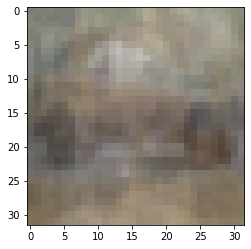

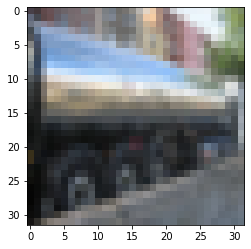

predicted truck
true truck
****************************************************************************************************


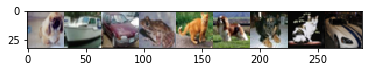

tensor([0.1167, 0.1036, 0.1372, 0.1454, 0.0984, 0.1442, 0.0804, 0.0914, 0.0827],
       device='cuda:0', dtype=torch.float64)


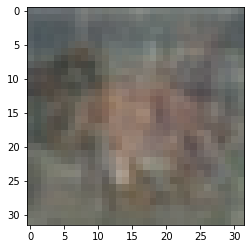

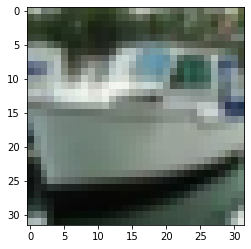

predicted ship
true ship
****************************************************************************************************


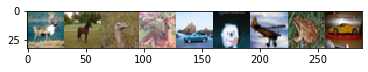

tensor([0.1076, 0.1373, 0.0937, 0.1167, 0.1459, 0.0756, 0.1133, 0.1005, 0.1093],
       device='cuda:0', dtype=torch.float64)


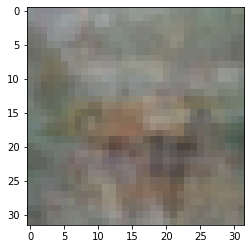

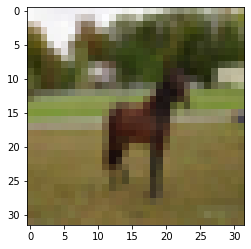

predicted truck
true horse
****************************************************************************************************


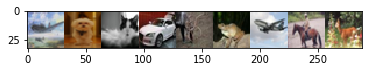

tensor([0.1425, 0.0856, 0.1677, 0.0781, 0.1034, 0.0979, 0.1135, 0.1130, 0.0982],
       device='cuda:0', dtype=torch.float64)


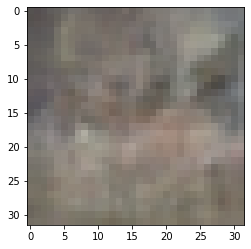

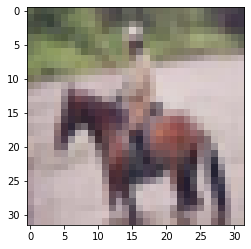

predicted horse
true horse
****************************************************************************************************


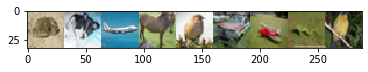

tensor([0.1388, 0.0911, 0.0916, 0.1435, 0.1331, 0.1177, 0.1012, 0.0967, 0.0864],
       device='cuda:0', dtype=torch.float64)


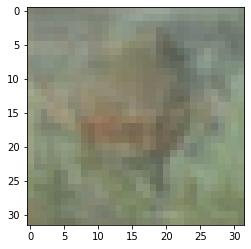

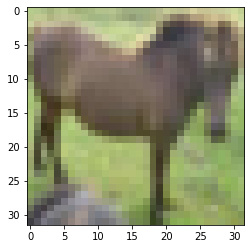

predicted horse
true horse
****************************************************************************************************


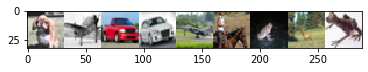

tensor([0.0864, 0.1107, 0.1546, 0.1152, 0.1607, 0.0785, 0.0710, 0.1070, 0.1159],
       device='cuda:0', dtype=torch.float64)


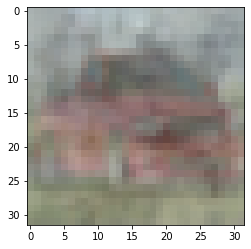

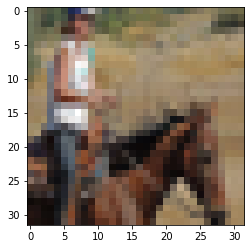

predicted horse
true horse
****************************************************************************************************


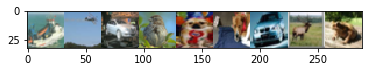

tensor([0.1083, 0.0854, 0.0849, 0.1085, 0.1096, 0.0925, 0.1069, 0.2049, 0.0990],
       device='cuda:0', dtype=torch.float64)


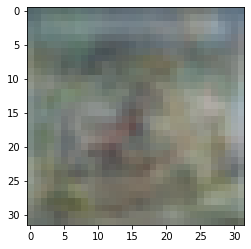

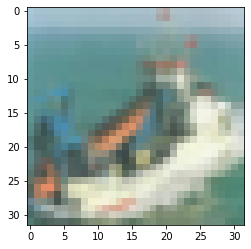

predicted ship
true ship
****************************************************************************************************


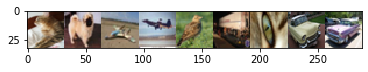

tensor([0.1106, 0.1517, 0.1526, 0.1090, 0.1019, 0.1102, 0.1026, 0.0838, 0.0775],
       device='cuda:0', dtype=torch.float64)


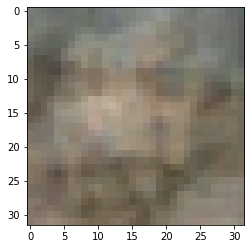

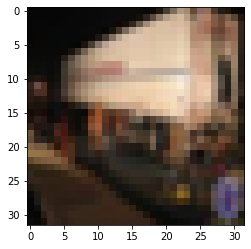

predicted truck
true truck
****************************************************************************************************


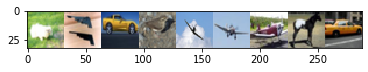

tensor([0.0878, 0.0852, 0.1160, 0.1000, 0.0876, 0.0690, 0.2076, 0.1321, 0.1146],
       device='cuda:0', dtype=torch.float64)


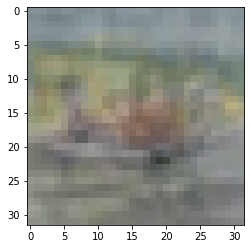

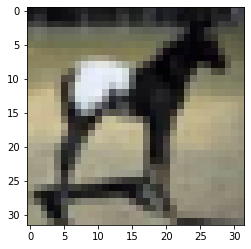

predicted horse
true horse
****************************************************************************************************


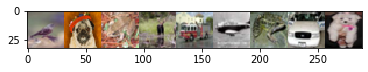

tensor([0.0851, 0.1071, 0.1115, 0.1097, 0.1613, 0.1347, 0.1014, 0.0750, 0.1143],
       device='cuda:0', dtype=torch.float64)


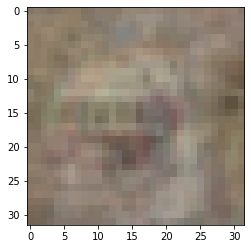

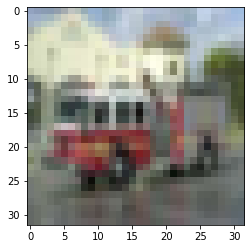

predicted truck
true truck
****************************************************************************************************


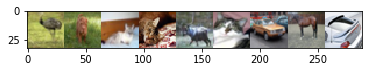

tensor([0.1339, 0.0865, 0.1857, 0.0859, 0.0767, 0.1160, 0.0927, 0.1125, 0.1103],
       device='cuda:0', dtype=torch.float64)


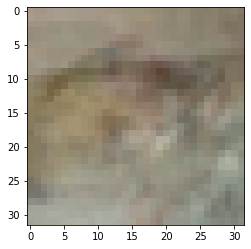

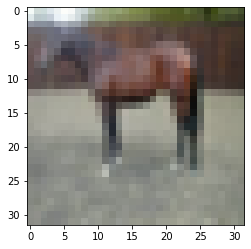

predicted horse
true horse
****************************************************************************************************


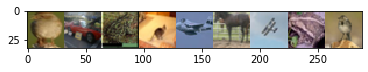

tensor([0.0923, 0.1468, 0.1071, 0.1195, 0.1012, 0.1375, 0.0928, 0.1110, 0.0918],
       device='cuda:0', dtype=torch.float64)


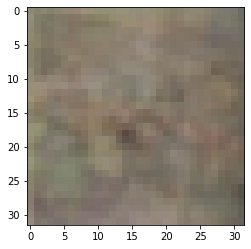

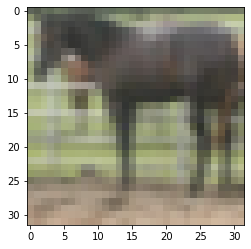

predicted horse
true horse
****************************************************************************************************


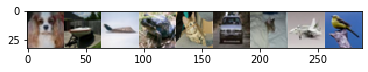

tensor([0.1089, 0.1095, 0.1004, 0.1599, 0.1160, 0.0840, 0.0987, 0.0864, 0.1361],
       device='cuda:0', dtype=torch.float64)


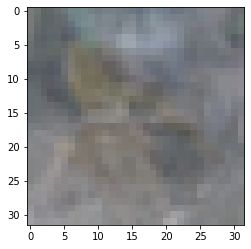

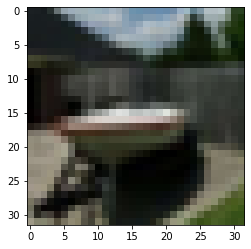

predicted ship
true ship
****************************************************************************************************


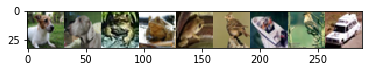

tensor([0.1609, 0.0796, 0.0826, 0.1997, 0.0896, 0.0856, 0.0693, 0.1065, 0.1262],
       device='cuda:0', dtype=torch.float64)


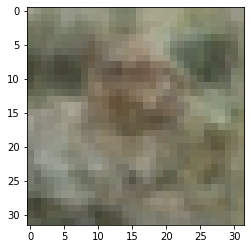

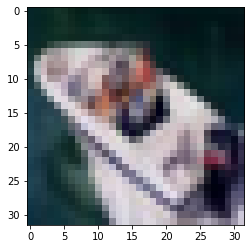

predicted ship
true ship
****************************************************************************************************


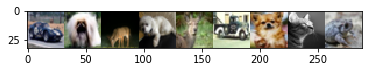

tensor([0.0828, 0.1316, 0.0938, 0.0987, 0.0926, 0.1334, 0.1379, 0.1265, 0.1027],
       device='cuda:0', dtype=torch.float64)


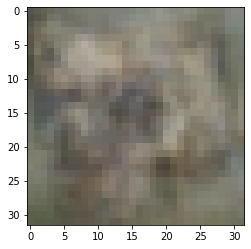

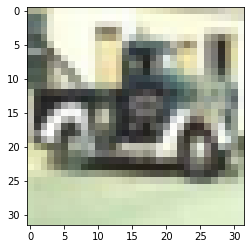

predicted truck
true truck
****************************************************************************************************


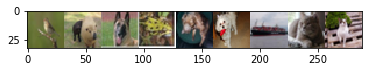

tensor([0.0965, 0.1329, 0.0951, 0.1007, 0.0907, 0.1081, 0.1597, 0.1228, 0.0935],
       device='cuda:0', dtype=torch.float64)


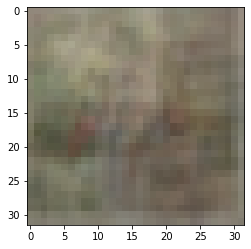

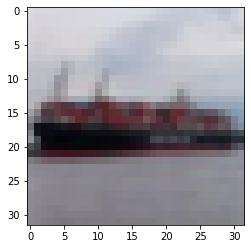

predicted ship
true ship
****************************************************************************************************


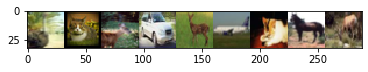

tensor([0.0825, 0.0787, 0.0751, 0.1202, 0.0975, 0.1084, 0.0823, 0.2505, 0.1046],
       device='cuda:0', dtype=torch.float64)


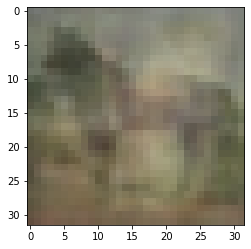

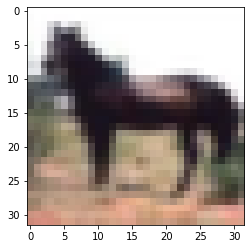

predicted horse
true horse
****************************************************************************************************


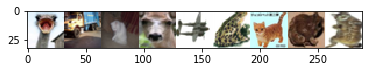

tensor([0.1237, 0.1594, 0.0770, 0.0876, 0.0734, 0.1294, 0.1442, 0.0899, 0.1155],
       device='cuda:0', dtype=torch.float64)


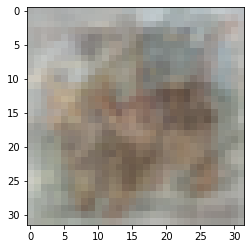

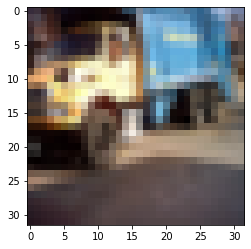

predicted truck
true truck
Accuracy of the network on the 30000 train images: 97 %
total correct 29270
total train set images 30000
focus_true_pred_true 18
focus_false_pred_true 31
focus_true_pred_false 0
focus_false_pred_false 1
argmax_more_than_half 0
argmax_less_than_half 50


In [33]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

6


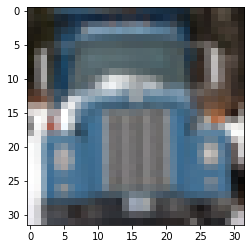

truck


In [36]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


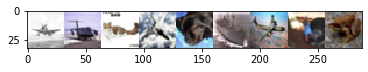

tensor([0.0887, 0.1081, 0.0891, 0.1020, 0.0744, 0.1517, 0.1651, 0.1377, 0.0833],
       device='cuda:0', dtype=torch.float64)


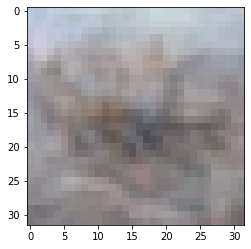

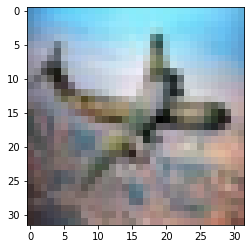

predicted truck
true ship
****************************************************************************************************


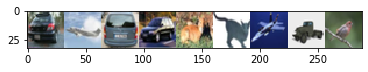

tensor([0.1355, 0.0897, 0.1599, 0.0981, 0.1331, 0.1007, 0.0939, 0.1092, 0.0799],
       device='cuda:0', dtype=torch.float64)


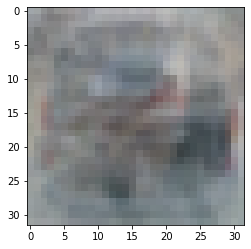

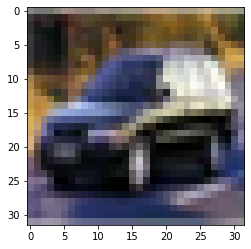

predicted truck
true truck
****************************************************************************************************


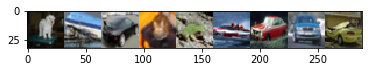

tensor([0.0918, 0.1457, 0.1340, 0.0855, 0.1051, 0.1221, 0.1149, 0.1050, 0.0958],
       device='cuda:0', dtype=torch.float64)


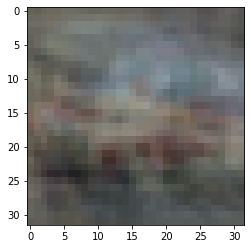

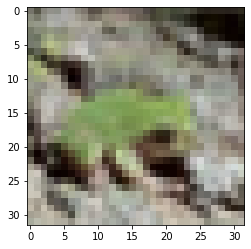

predicted ship
true ship
****************************************************************************************************


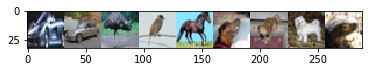

tensor([0.1021, 0.0860, 0.1113, 0.0973, 0.1639, 0.0812, 0.1341, 0.0771, 0.1470],
       device='cuda:0', dtype=torch.float64)


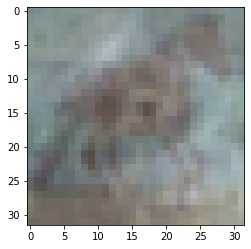

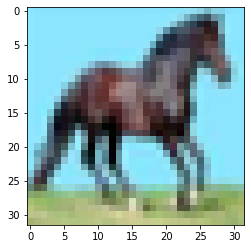

predicted horse
true horse
****************************************************************************************************


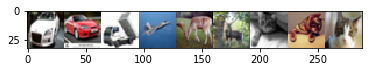

tensor([0.1129, 0.0796, 0.1577, 0.1029, 0.0912, 0.1341, 0.0804, 0.1121, 0.1291],
       device='cuda:0', dtype=torch.float64)


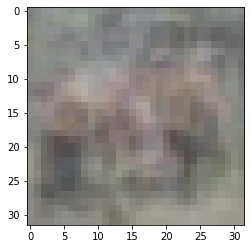

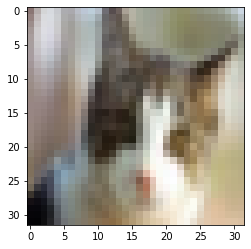

predicted horse
true truck
****************************************************************************************************


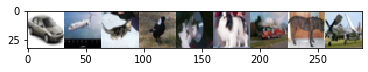

tensor([0.1162, 0.1248, 0.0779, 0.0904, 0.0899, 0.0800, 0.1490, 0.1170, 0.1548],
       device='cuda:0', dtype=torch.float64)


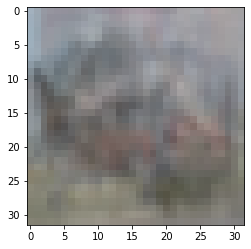

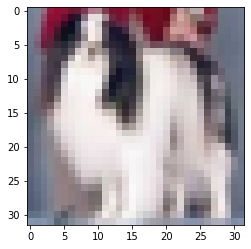

predicted truck
true truck
****************************************************************************************************


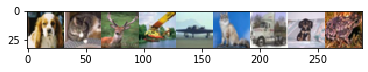

tensor([0.1565, 0.0774, 0.0780, 0.1535, 0.1233, 0.0881, 0.1604, 0.0959, 0.0670],
       device='cuda:0', dtype=torch.float64)


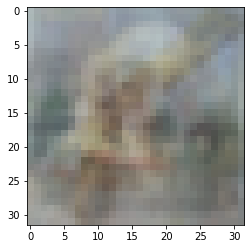

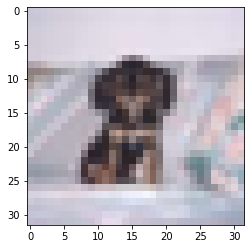

predicted ship
true truck
****************************************************************************************************


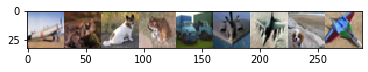

tensor([0.1637, 0.0753, 0.0828, 0.1189, 0.1455, 0.1223, 0.0997, 0.1039, 0.0878],
       device='cuda:0', dtype=torch.float64)


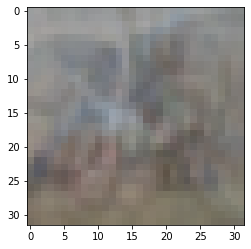

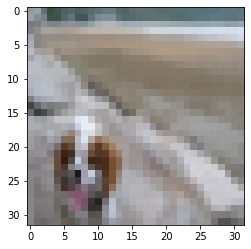

predicted truck
true truck
****************************************************************************************************


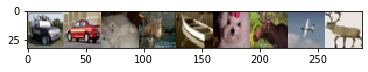

tensor([0.2080, 0.1063, 0.0778, 0.1069, 0.0987, 0.1056, 0.0921, 0.0953, 0.1093],
       device='cuda:0', dtype=torch.float64)


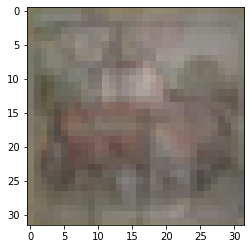

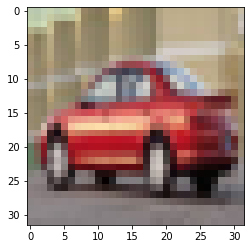

predicted ship
true ship
****************************************************************************************************


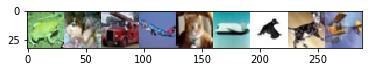

tensor([0.1085, 0.1200, 0.1419, 0.0879, 0.0957, 0.1010, 0.1134, 0.1055, 0.1261],
       device='cuda:0', dtype=torch.float64)


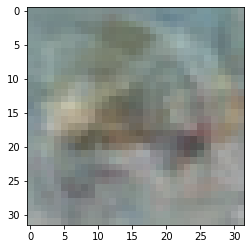

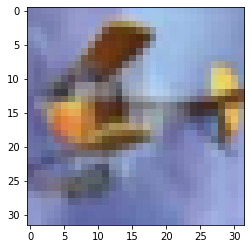

predicted ship
true truck
****************************************************************************************************


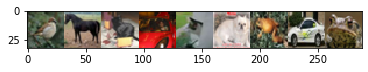

tensor([0.0828, 0.2144, 0.1084, 0.0741, 0.1214, 0.0894, 0.0996, 0.1130, 0.0969],
       device='cuda:0', dtype=torch.float64)


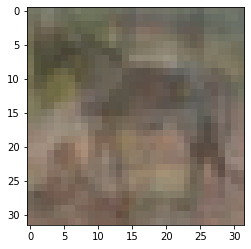

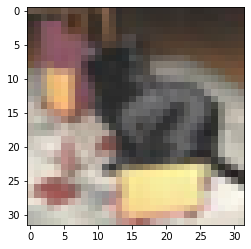

predicted horse
true horse
****************************************************************************************************


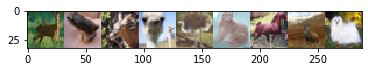

tensor([0.0945, 0.1167, 0.0885, 0.0969, 0.0913, 0.1129, 0.1301, 0.1948, 0.0743],
       device='cuda:0', dtype=torch.float64)


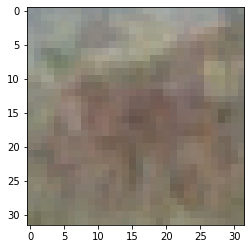

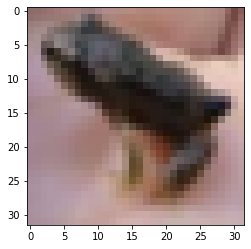

predicted horse
true horse
****************************************************************************************************


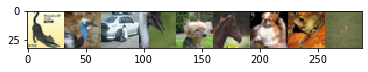

tensor([0.1473, 0.0976, 0.1244, 0.1277, 0.1262, 0.0901, 0.0960, 0.0869, 0.1040],
       device='cuda:0', dtype=torch.float64)


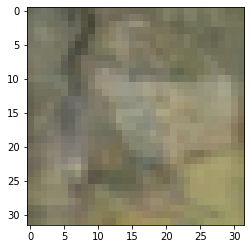

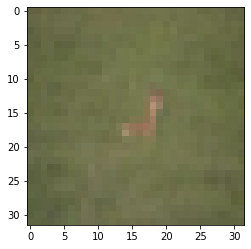

predicted truck
true horse
****************************************************************************************************


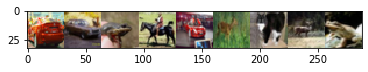

tensor([0.1826, 0.0963, 0.0749, 0.1405, 0.1447, 0.0905, 0.1126, 0.0821, 0.0759],
       device='cuda:0', dtype=torch.float64)


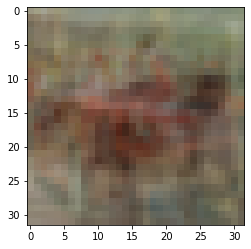

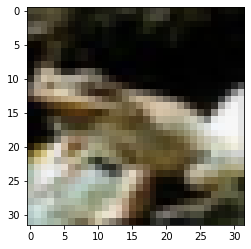

predicted truck
true horse
****************************************************************************************************


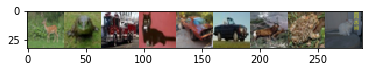

tensor([0.0899, 0.0961, 0.1735, 0.0837, 0.0840, 0.1660, 0.1374, 0.0847, 0.0848],
       device='cuda:0', dtype=torch.float64)


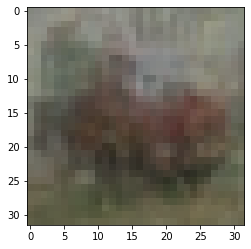

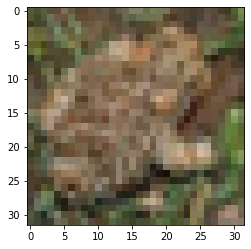

predicted horse
true truck
****************************************************************************************************


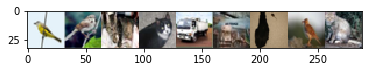

tensor([0.0970, 0.1030, 0.0974, 0.1016, 0.1562, 0.0938, 0.1014, 0.1681, 0.0817],
       device='cuda:0', dtype=torch.float64)


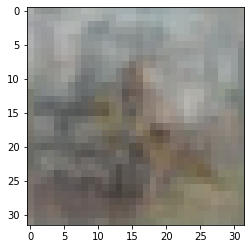

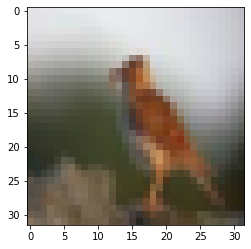

predicted truck
true truck
****************************************************************************************************


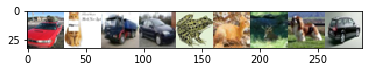

tensor([0.1530, 0.0718, 0.1530, 0.1424, 0.1124, 0.0920, 0.0688, 0.1102, 0.0964],
       device='cuda:0', dtype=torch.float64)


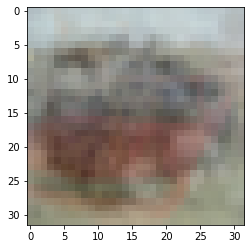

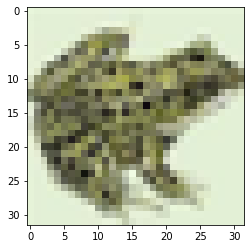

predicted truck
true truck
****************************************************************************************************


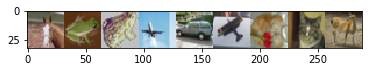

tensor([0.1080, 0.0951, 0.1229, 0.0906, 0.0963, 0.1243, 0.1137, 0.1212, 0.1280],
       device='cuda:0', dtype=torch.float64)


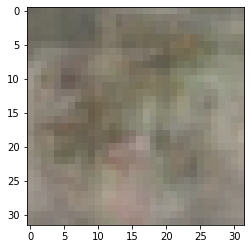

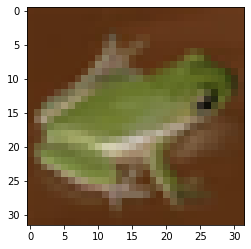

predicted truck
true horse
****************************************************************************************************


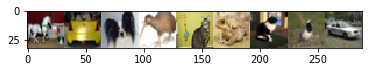

tensor([0.0947, 0.0905, 0.1242, 0.1002, 0.1206, 0.1371, 0.1303, 0.1154, 0.0870],
       device='cuda:0', dtype=torch.float64)


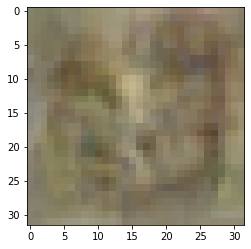

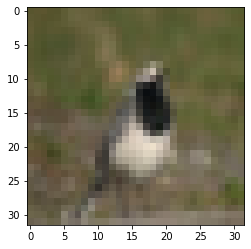

predicted truck
true horse
****************************************************************************************************


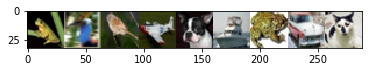

tensor([0.1061, 0.1037, 0.0839, 0.0794, 0.1268, 0.1597, 0.1137, 0.1167, 0.1099],
       device='cuda:0', dtype=torch.float64)


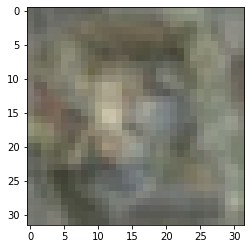

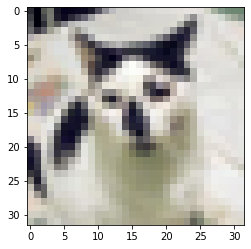

predicted truck
true ship
****************************************************************************************************


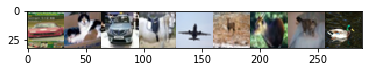

tensor([0.0918, 0.1232, 0.0961, 0.1149, 0.0883, 0.1210, 0.1157, 0.1153, 0.1337],
       device='cuda:0', dtype=torch.float64)


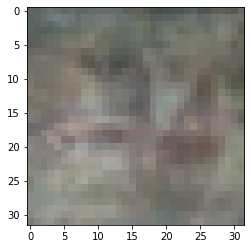

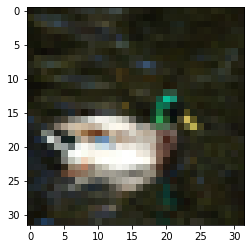

predicted ship
true horse
****************************************************************************************************


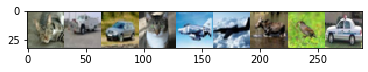

tensor([0.1113, 0.1683, 0.0836, 0.1047, 0.0871, 0.1308, 0.1002, 0.1226, 0.0914],
       device='cuda:0', dtype=torch.float64)


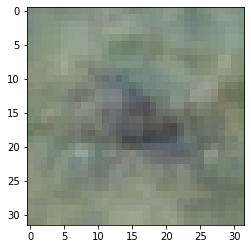

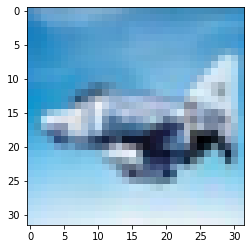

predicted horse
true truck
****************************************************************************************************


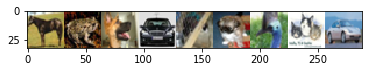

tensor([0.1839, 0.0657, 0.1061, 0.1632, 0.0864, 0.0878, 0.1093, 0.0846, 0.1130],
       device='cuda:0', dtype=torch.float64)


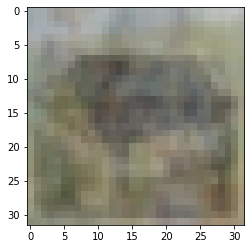

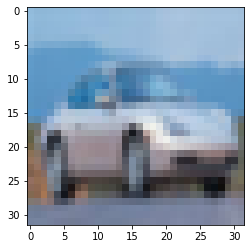

predicted horse
true horse
****************************************************************************************************


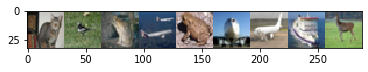

tensor([0.1436, 0.0872, 0.0880, 0.1068, 0.0910, 0.1161, 0.1151, 0.1294, 0.1227],
       device='cuda:0', dtype=torch.float64)


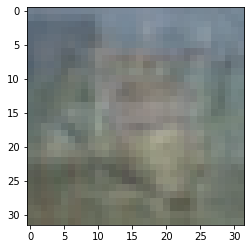

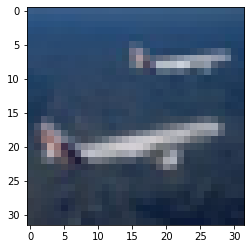

predicted horse
true ship
****************************************************************************************************


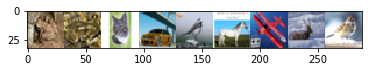

tensor([0.0847, 0.1035, 0.0902, 0.1107, 0.1361, 0.1477, 0.1358, 0.0965, 0.0949],
       device='cuda:0', dtype=torch.float64)


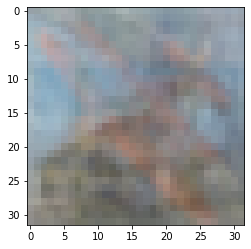

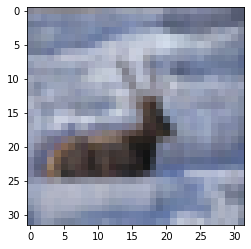

predicted truck
true horse
****************************************************************************************************


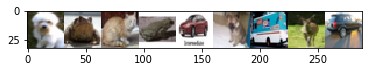

tensor([0.1077, 0.0954, 0.0859, 0.1423, 0.1244, 0.0758, 0.1052, 0.0827, 0.1807],
       device='cuda:0', dtype=torch.float64)


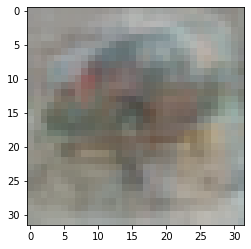

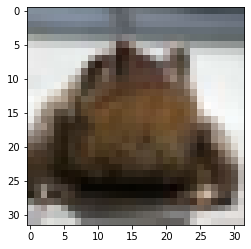

predicted truck
true truck
****************************************************************************************************


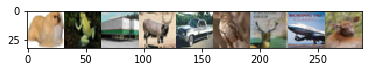

tensor([0.1317, 0.0961, 0.1419, 0.1052, 0.1135, 0.1007, 0.1158, 0.1015, 0.0936],
       device='cuda:0', dtype=torch.float64)


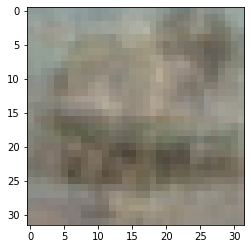

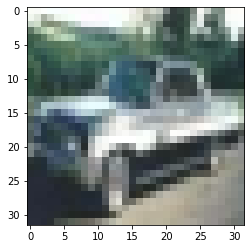

predicted truck
true truck
****************************************************************************************************


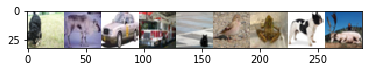

tensor([0.1131, 0.1010, 0.1277, 0.0911, 0.1018, 0.0963, 0.0983, 0.1283, 0.1424],
       device='cuda:0', dtype=torch.float64)


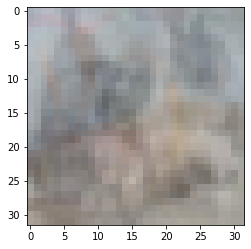

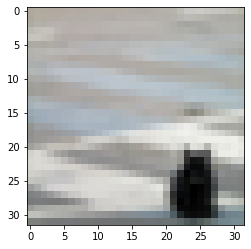

predicted truck
true truck
****************************************************************************************************


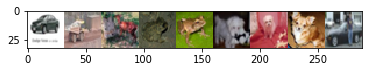

tensor([0.1418, 0.1170, 0.1161, 0.1009, 0.1017, 0.0863, 0.1197, 0.1069, 0.1095],
       device='cuda:0', dtype=torch.float64)


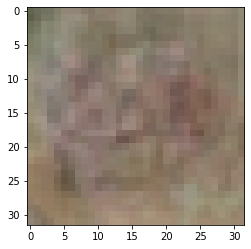

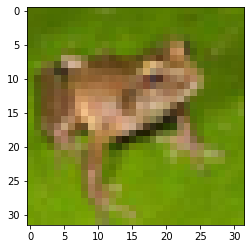

predicted truck
true truck
****************************************************************************************************


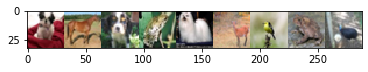

tensor([0.1495, 0.1739, 0.1054, 0.0901, 0.0823, 0.0871, 0.1159, 0.0809, 0.1148],
       device='cuda:0', dtype=torch.float64)


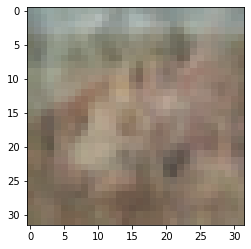

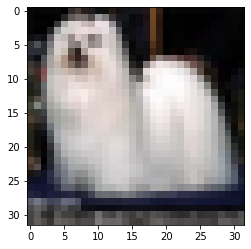

predicted horse
true horse
****************************************************************************************************


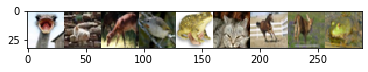

tensor([0.1401, 0.0937, 0.0981, 0.0794, 0.1146, 0.0795, 0.1742, 0.1120, 0.1086],
       device='cuda:0', dtype=torch.float64)


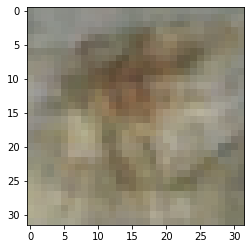

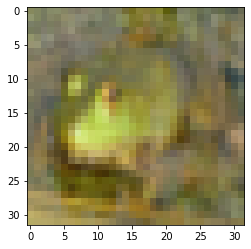

predicted horse
true horse
****************************************************************************************************


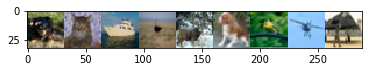

tensor([0.0942, 0.1164, 0.1423, 0.1357, 0.0801, 0.0987, 0.0890, 0.0692, 0.1744],
       device='cuda:0', dtype=torch.float64)


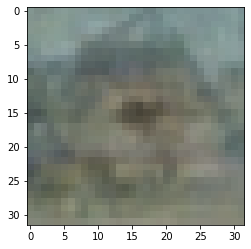

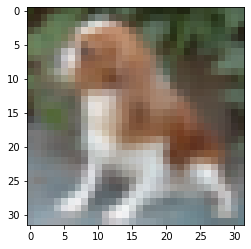

predicted ship
true ship
****************************************************************************************************


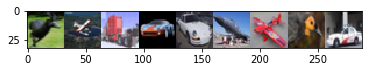

tensor([0.1025, 0.0896, 0.1498, 0.0723, 0.0883, 0.1397, 0.1258, 0.0975, 0.1345],
       device='cuda:0', dtype=torch.float64)


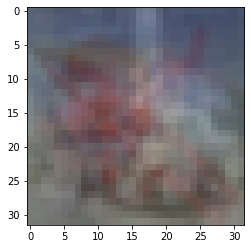

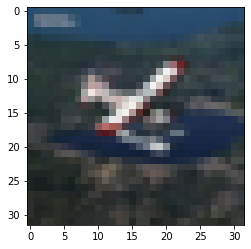

predicted truck
true truck
****************************************************************************************************


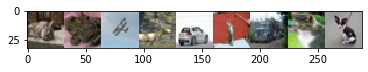

tensor([0.0871, 0.0857, 0.0799, 0.1176, 0.1321, 0.0776, 0.1905, 0.0981, 0.1315],
       device='cuda:0', dtype=torch.float64)


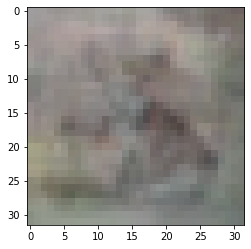

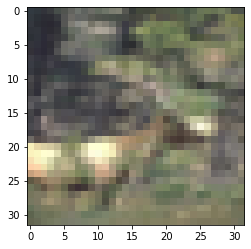

predicted truck
true truck
****************************************************************************************************


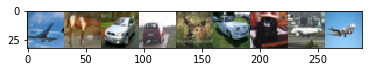

tensor([0.0935, 0.1153, 0.0903, 0.1705, 0.1160, 0.1263, 0.1115, 0.0953, 0.0813],
       device='cuda:0', dtype=torch.float64)


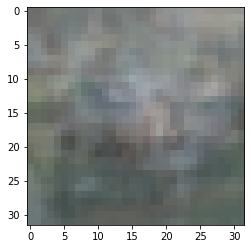

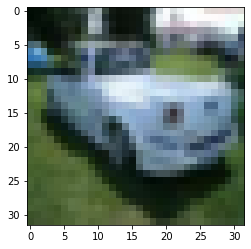

predicted truck
true horse
****************************************************************************************************


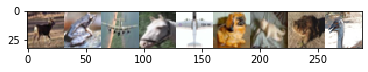

tensor([0.1217, 0.0929, 0.1297, 0.1154, 0.0862, 0.1523, 0.1060, 0.1120, 0.0840],
       device='cuda:0', dtype=torch.float64)


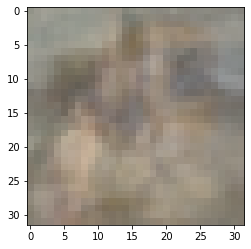

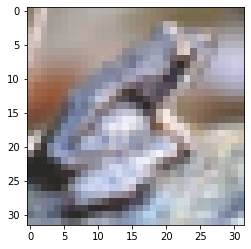

predicted truck
true horse
****************************************************************************************************


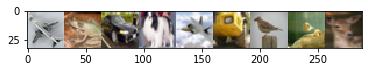

tensor([0.1027, 0.0891, 0.1269, 0.0866, 0.1171, 0.1290, 0.1394, 0.1135, 0.0956],
       device='cuda:0', dtype=torch.float64)


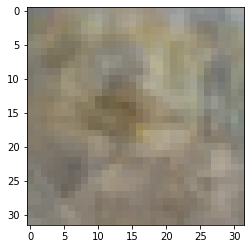

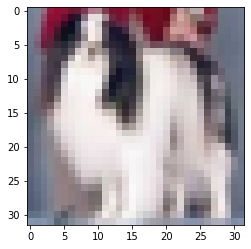

predicted ship
true truck
****************************************************************************************************


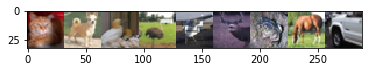

tensor([0.0662, 0.0959, 0.0870, 0.1714, 0.1229, 0.0788, 0.0874, 0.1799, 0.1105],
       device='cuda:0', dtype=torch.float64)


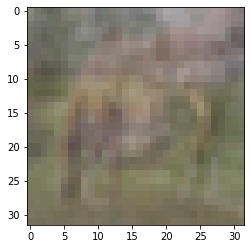

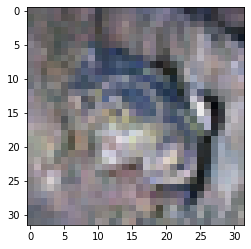

predicted horse
true horse
****************************************************************************************************


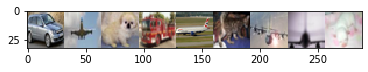

tensor([0.1168, 0.0865, 0.1193, 0.1890, 0.0880, 0.0977, 0.0970, 0.1135, 0.0922],
       device='cuda:0', dtype=torch.float64)


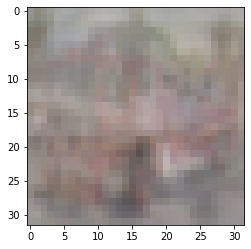

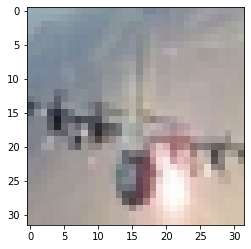

predicted truck
true truck
****************************************************************************************************


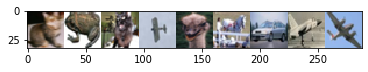

tensor([0.0982, 0.1152, 0.0902, 0.0938, 0.1175, 0.1038, 0.1455, 0.1292, 0.1066],
       device='cuda:0', dtype=torch.float64)


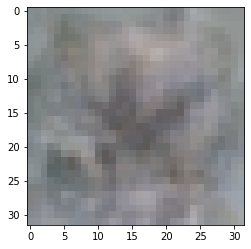

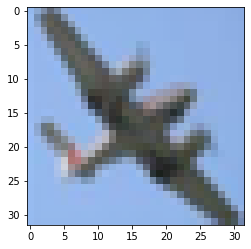

predicted horse
true horse
****************************************************************************************************


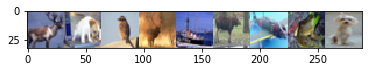

tensor([0.1055, 0.1141, 0.1102, 0.0960, 0.1312, 0.1162, 0.1241, 0.1066, 0.0961],
       device='cuda:0', dtype=torch.float64)


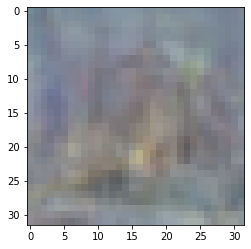

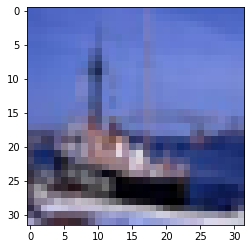

predicted truck
true ship
****************************************************************************************************


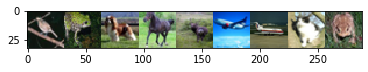

tensor([0.0803, 0.0842, 0.1572, 0.1495, 0.1388, 0.0704, 0.1014, 0.1165, 0.1018],
       device='cuda:0', dtype=torch.float64)


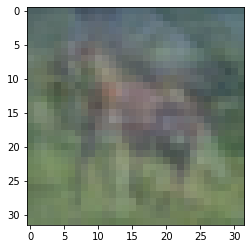

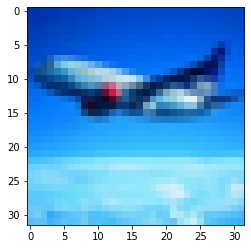

predicted horse
true horse
****************************************************************************************************


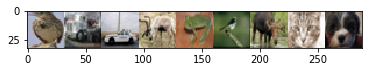

tensor([0.0986, 0.1405, 0.1349, 0.1478, 0.0955, 0.0933, 0.0947, 0.0987, 0.0960],
       device='cuda:0', dtype=torch.float64)


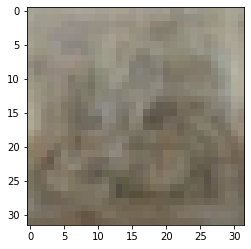

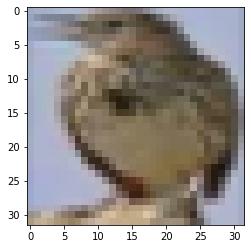

predicted truck
true truck
****************************************************************************************************


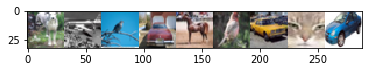

tensor([0.1502, 0.0990, 0.0834, 0.1075, 0.1923, 0.1030, 0.1051, 0.0889, 0.0708],
       device='cuda:0', dtype=torch.float64)


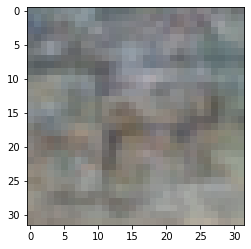

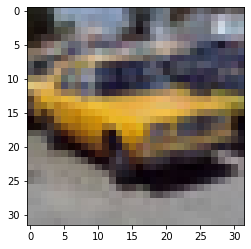

predicted horse
true horse
****************************************************************************************************


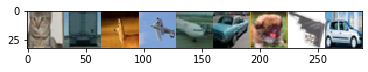

tensor([0.1090, 0.1128, 0.1060, 0.0885, 0.1020, 0.0857, 0.1312, 0.1211, 0.1436],
       device='cuda:0', dtype=torch.float64)


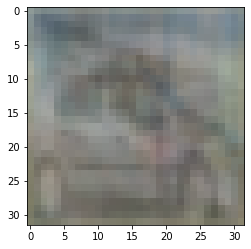

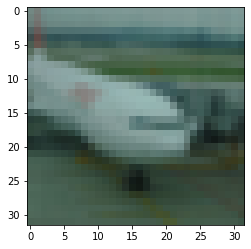

predicted truck
true truck
****************************************************************************************************


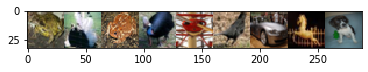

tensor([0.1129, 0.1366, 0.1031, 0.1220, 0.1325, 0.1004, 0.0938, 0.0894, 0.1093],
       device='cuda:0', dtype=torch.float64)


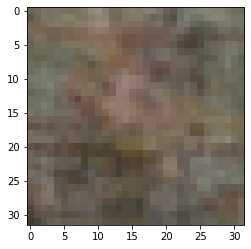

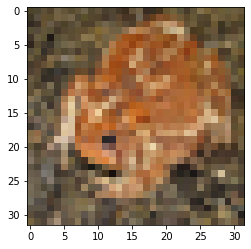

predicted truck
true horse
****************************************************************************************************


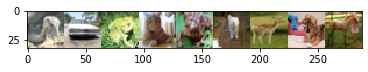

tensor([0.0860, 0.1253, 0.1060, 0.1237, 0.1210, 0.1070, 0.1002, 0.1242, 0.1067],
       device='cuda:0', dtype=torch.float64)


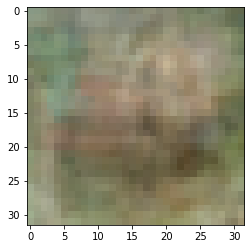

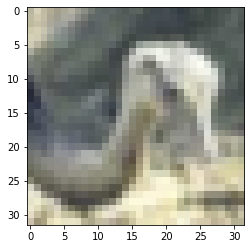

predicted truck
true horse
****************************************************************************************************


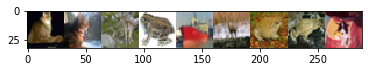

tensor([0.1005, 0.1530, 0.0943, 0.1212, 0.1288, 0.1054, 0.0827, 0.0894, 0.1248],
       device='cuda:0', dtype=torch.float64)


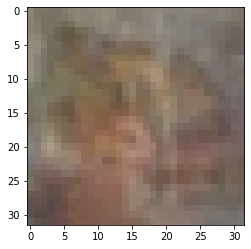

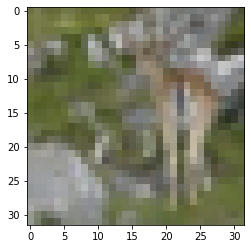

predicted horse
true ship
****************************************************************************************************


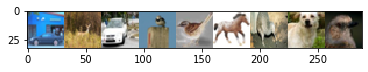

tensor([0.1039, 0.1114, 0.0822, 0.1109, 0.1087, 0.1138, 0.1176, 0.1512, 0.1003],
       device='cuda:0', dtype=torch.float64)


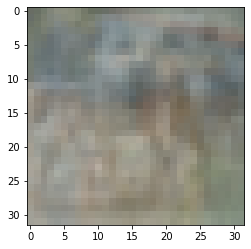

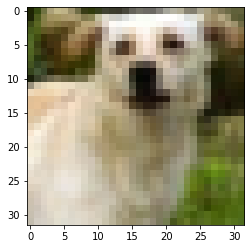

predicted horse
true horse
****************************************************************************************************


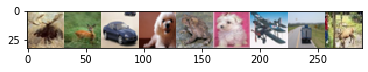

tensor([0.1441, 0.0885, 0.1076, 0.1561, 0.0829, 0.1067, 0.1001, 0.1335, 0.0804],
       device='cuda:0', dtype=torch.float64)


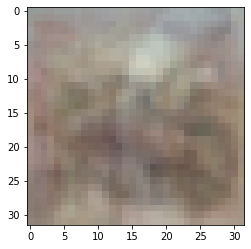

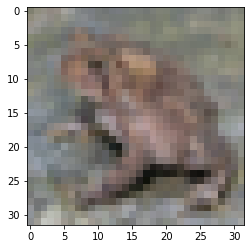

predicted truck
true truck
Accuracy of the network on the 10000 test images: 43 %
total correct 4337
total test set images 10000


In [37]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [39]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [40]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29270
total train set images 30000
focus_true_pred_true 9984
focus_false_pred_true 19286
focus_true_pred_false 209
focus_false_pred_false 521
argmax_more_than_half 0
argmax_less_than_half 30000


In [41]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 43 %
total correct 4337
total train set images 10000
focus_true_pred_true 1709
focus_false_pred_true 2628
focus_true_pred_false 1694
focus_false_pred_false 3969
argmax_more_than_half 0
argmax_less_than_half 10000


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)